In [1]:
library(ggplot2)
library(boot)

In [2]:
base_path <- getwd()
setwd(base_path)
set.seed(42)

# 1.1. Delta method

In [3]:
data(city, package = "boot")
city

,u,x
,<dbl>,<dbl>
1,138,143
2,93,104
3,61,69
4,179,260
5,48,75
6,37,63
7,29,50
8,23,48
9,30,111


In [4]:
dim(city)

[1] 10  2

In [5]:
mean_1920 <- mean(city$u)
mean_1930 <- mean(city$x)
theta_est <- mean_1930/mean_1920
theta_est

[1] 1.520312

In [6]:
cor(city$u, city$x, method = "spearman")

[1] 0.8449887

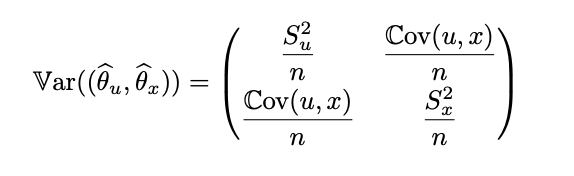

In [7]:
n_city <- nrow(city)
var_1920 <- var(city$u)
var_1930 <- var(city$x)
cov_ux <- cov(city$u, city$x)
var_mean_ux <- matrix(c(var_1920, cov_ux, cov_ux, var_1930), 2, 2)/n_city
var_mean_ux

316.0222,331.0889
331.0889,424.1344


In [8]:
cov_ux

[1] 3310.889

In [9]:
h_deriv <- function(mean_1, mean_2){
# mean_2/mean_1
return(c(-mean_2/mean_1^2, 1/mean_1))
}
h_deriv_est <- h_deriv(mean_1 = mean_1920, mean_2 = mean_1930)
h_deriv_est

[1] -0.02375488  0.01562500

In [10]:
# Tiếp theo, ta tính phương sai của ước lượng tỷ số trung bình
var_theta_est <- h_deriv_est %*% var_mean_ux %*% h_deriv_est
var_theta_est

0.03609748


In [11]:
city

,u,x
,<dbl>,<dbl>
1,138,143
2,93,104
3,61,69
4,179,260
5,48,75
6,37,63
7,29,50
8,23,48
9,30,111


# THỰC HÀNH 1:
 - Áp dụng phương pháp delta method vào trong quy trình bootstrap để xác định khoảng tin cậy studentized cho tỷ số trung bình của năm 1930 và 1920.

In [12]:
var_delta_method <- function(df_new){
    n_city <- nrow(df_new)
    var_1920 <- var(df_new$u)
    var_1930 <- var(df_new$x)
    cov_ux <- cov(df_new$u, df_new$x)
    var_mean_ux <- matrix(c(var_1920, cov_ux, cov_ux, var_1930), 2, 2)/n_city
    h_deriv_est = h_deriv(mean_1 = mean(df_new$u), mean(df_new$x))
    var_theta_est <- h_deriv_est %*% var_mean_ux %*% h_deriv_est
    return(var_theta_est)
}

In [13]:

# Bootstrap cho sự khác biệt hai khoảng thời gian trung bình
boot_diff_mean_fun <- function(data, ind){
    data_new <- data[ind, c("u", "x")]
    out_diff_mean <- mean(data_new[["x"]]) / mean(data_new[["u"]])
    out_var_ux = var_delta_method(data_new)
    return(c(out_diff_mean,out_var_ux))
}

In [14]:
boot_out = boot(data = city, statistic = boot_diff_mean_fun, R = 1000)
boot_out


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = city, statistic = boot_diff_mean_fun, R = 1000)


Bootstrap Statistics :
      original     bias    std. error
t1* 1.52031250 0.04734245  0.23647477
t2* 0.03609748 0.01816789  0.06799995

In [15]:
# Khoảng tin cậy bootsrap 95%:
boot.ci(boot_out, conf = 0.95, type = "all")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_out, conf = 0.95, type = "all")

Intervals : 
Level      Normal              Basic             Studentized     
95%   ( 1.009,  1.936 )   ( 0.911,  1.790 )   ( 1.242,  2.083 )  

Level     Percentile            BCa          
95%   ( 1.250,  2.130 )   ( 1.255,  2.170 )  
Calculations and Intervals on Original Scale

## Thực hành 2: 
Thực hiện quy trình bootstrap để xác định khoảng tin cậy cho log() của tỷ số hai trung bình, sau đó, thực hiện biến đổi ngược để thu được khoảng tin cậy cho tỷ số trung bình.


In [16]:
var_delta_method_log <- function(df_new){
    n_city <- nrow(df_new)
    var_1920 <- var(df_new$u)
    var_1930 <- var(df_new$x)
    cov_ux <- cov(df_new$u, df_new$x)
    var_mean_ux <- matrix(c(var_1920, cov_ux, cov_ux, var_1930), 2, 2)/n_city
    h_deriv_est = h_deriv(mean_1 = mean(df_new$u), mean(df_new$x))
    var_theta_est <- h_deriv_est %*% var_mean_ux %*% h_deriv_est
    var_log_theta = var_theta_est * (1/(mean(df_new$x)/mean(df_new$u)))^2
    return(var_log_theta)
}

In [17]:

# Bootstrap cho sự khác biệt hai khoảng thời gian trung bình
boot_diff_log_mean_fun <- function(data, ind){
    data_new <- data[ind, c("u", "x")]
    out_diff_mean <- log(mean(data_new[["x"]]) / mean(data_new[["u"]]))
    out_var_ux = var_delta_method_log(data_new)
    return(c(out_diff_mean,out_var_ux))
}

In [18]:
boot_log_out = boot(data = city, statistic = boot_diff_log_mean_fun, R = 1000)
boot_log_out


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = city, statistic = boot_diff_log_mean_fun, R = 1000)


Bootstrap Statistics :
      original      bias    std. error
t1* 0.41891591 0.017572927  0.13278213
t2* 0.01561749 0.001952544  0.01298153

In [19]:
# Khoảng tin cậy bootsrap 95%:
ktc = boot.ci(boot_log_out, conf = 0.95, type = "all")
ktc

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_log_out, conf = 0.95, type = "all")

Intervals : 
Level      Normal              Basic             Studentized     
95%   ( 0.1411,  0.6616 )   ( 0.0677,  0.6050 )   ( 0.2099,  0.7656 )  

Level     Percentile            BCa          
95%   ( 0.2329,  0.7701 )   ( 0.2330,  0.7741 )  
Calculations and Intervals on Original Scale

In [20]:
exp(ktc$student[4:5])

[1] 1.233604 2.150186

# THỰC HÀNH 3:
- Một nghiên cứu lớn về mối liên quan giữa huyết áp và bệnh tim mạch cho thấy 55 trong số 3338 nam giới bị huyết áp cao chết vì bệnh tim mạch (p1) trong thời gian nghiên cứu, so với 21 trong số 2676 người bị huyết áp thấp (p2). Rủi ro tương đối (Relative risk) được định nghĩa là tỷ số giữa hai tỷ lệ.
    - (a) Áp dụng delta method, ước tính phương sai của rủi ro tương đối (p1/p2).
    - (b) Thiết lập một quy trình bootstrap để xác định khoảng tin cậy cho tỷ lệ tương đối xác định theo ý (a).

In [21]:

cao = c(rep(1, 55), rep(0, 3283))
thap = c(rep(1, 21), rep(0, 2655))


In [22]:
# # Xác định độ dài lớn nhất
# max_length <- max(length(cao), length(thap))

In [23]:
# df <- data.frame(
#   cao = c(cao, rep(NA, max_length - length(cao))),
#   thap = c(thap, rep(NA, max_length - length(thap)))
# )

In [24]:
# var_delta_method_th3 <- function(data){
#     n_cao = sum(!is.na(data$cao))
#     # print(n_cao)
#     n_thap = sum(!is.na(data$thap))
#     # print(n_thap)
#     var_cao <- var(data$cao, na.rm = TRUE)
#     # print(var_cao)
#     var_thap <- var(data$thap, na.rm = TRUE)
#     # print(var_thap)
#     cov_ux = 0
#     var_mean_ux <- matrix(c(var_thap/n_thap, cov_ux, cov_ux, var_cao/n_cao), 2, 2)
#     h_deriv_est = h_deriv(mean_1 = mean(thap, na.rm = TRUE), mean_2 = mean(cao, na.rm = TRUE))
#     var_theta_est <- h_deriv_est %*% var_mean_ux %*% h_deriv_est
#     return(var_theta_est)
# }

In [25]:
var_delta_method_th3 <- function(cao, thap){
    n_cao = length(cao)
    n_thap = length(thap)
    var_cao <- (1/n_cao)*(mean(cao)*(1-mean(cao)))
    var_thap <- (1/n_thap)*(mean(thap)*(1-mean(thap)))
    # var_cao <- var(cao)
    # var_thap <- var(thap)
    cov_ux = 0
    var_mean_ux <- matrix(c(var_thap, cov_ux, cov_ux, var_cao), 2, 2)
    h_deriv_est = h_deriv(mean_1 = mean(thap), mean_2 = mean(cao))
    var_theta_est <- h_deriv_est %*% var_mean_ux %*% h_deriv_est
    return(var_theta_est)
}

In [26]:
nR <- 1000 # Số mẫu Boostrap
mu_boot <- numeric(nR)
var_boot = numeric(nR)
n_cao = length(cao)
n_thap = length(thap)
set.seed(42)
for (i in 1:nR) {
cao_boot <- sample(cao, size = n_cao, replace = TRUE)
thap_boot <- sample(thap, size = n_thap, replace = TRUE)
# cao_boot <- cao[id_boot_cao]
# thap_boot <- thap[id_boot_thap]
mu_boot[i] <- mean(cao_boot)/mean(thap_boot)
var_boot[i] = var_delta_method_th3(cao_boot, thap_boot)
}

In [33]:
# Trung bình của mẫu
mu = mean(cao)/mean(thap)
var = var_delta_method_th3(cao, thap)
mu


[1] 2.099632

In [28]:
# Khi này ta tính được Z*
z_boot = (mu_boot - mu)/var_boot

In [29]:
# Khi đó hai phân vị mẫu thứ 0.025 và 0.975 là:
z_qt_095 <- sort(z_boot)[floor(nR*c(1 - 0.05/2 , 0.05/2))]
z_qt_095

[1]  1.426278 -8.012839

In [30]:
var

0.287112


In [31]:
# Như vậy khoảng tin cậy bootstrap studentized 95% cho trung bình ứng suất của 1 mẫu là:
se_mu <- as.numeric(sqrt(var))
ci <- mu - se_mu*z_qt_095
ci


[1] 1.335392 6.393138

# 1.2 Influence function - nonparametric delta method

In [ ]:
ratio_city_fun_w <- function(data, w){
mean_1 <- sum(data$u * w)/sum(w)
mean_2 <- sum(data$x * w)/sum(w)
return(mean_2/mean_1)
}

# 2. Các biến thể của bootstrap

## 2.1. Parametric bootstrap

In [ ]:
data(aircondit, package = "boot")
head(aircondit)

,hours
,<dbl>
1,3
2,5
3,7
4,18
5,43
6,85


In [ ]:
mean_hours <- mean(aircondit$hours)
mean_hours

[1] 108.0833

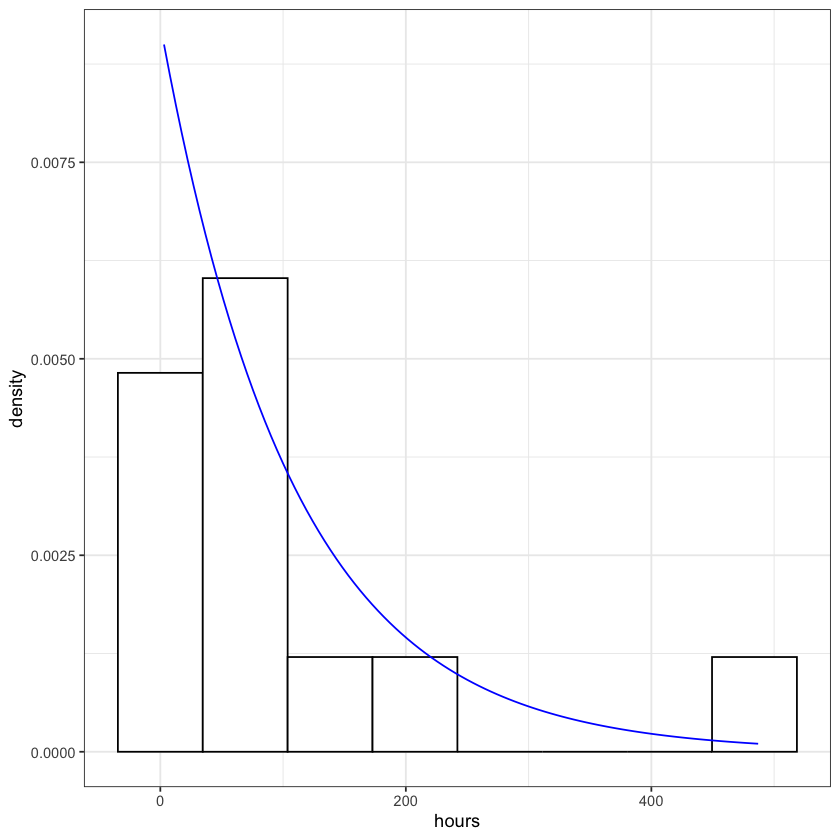

In [ ]:
ggplot(aircondit, mapping = aes(x = hours)) + geom_histogram(mapping = aes(y = after_stat(density)), bins = 8,
fill = "white", color = "black") +
geom_function(fun = dexp, args = list(rate = 1/mean_hours), color = "blue") + theme_bw()

In [ ]:
aircondit_mean <- function(data) mean(data$hours)

In [ ]:
aircondit_sim <- function(data, mle){
data <- data
data$hours <- rexp(n = nrow(data), rate = mle)
return(data)
}

In [ ]:
out_boot_aircondit <- boot(data = aircondit, statistic = aircondit_mean, R = 5000, sim = "parametric", ran.gen = aircondit_sim,
mle = 1/mean_hours)

In [ ]:
out_boot_aircondit


PARAMETRIC BOOTSTRAP


Call:
boot(data = aircondit, statistic = aircondit_mean, R = 5000, 
    sim = "parametric", ran.gen = aircondit_sim, mle = 1/mean_hours)


Bootstrap Statistics :
    original     bias    std. error
t1* 108.0833 -0.2156096     31.1734

In [ ]:
boot.ci(out_boot_aircondit, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 5000 bootstrap replicates

CALL : 
boot.ci(boot.out = out_boot_aircondit, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 57.3, 177.6 )  
Calculations and Intervals on Original Scale

## 2.2. Smoothed bootstrap

In [ ]:
data(aircondit, package = "boot")

In [ ]:
h_nrd0 <- bw.nrd0(aircondit$hours)
h_nrd <- bw.nrd(aircondit$hours)
h_ucv <- bw.ucv(aircondit$hours)
h_bcv <- bw.bcv(aircondit$hours)

Warning message in bw.bcv(aircondit$hours):
"minimum occurred at one end of the range"


In [ ]:
h_SJ <- bw.SJ(aircondit$hours)

In [ ]:
h_nrd0

[1] 37.69362

In [ ]:
h_nrd

[1] 44.39471

In [ ]:
h_ucv

[1] 62.21936

In [ ]:
h_bcv

[1] 94.20066

In [ ]:
h_SJ

[1] 22.92677

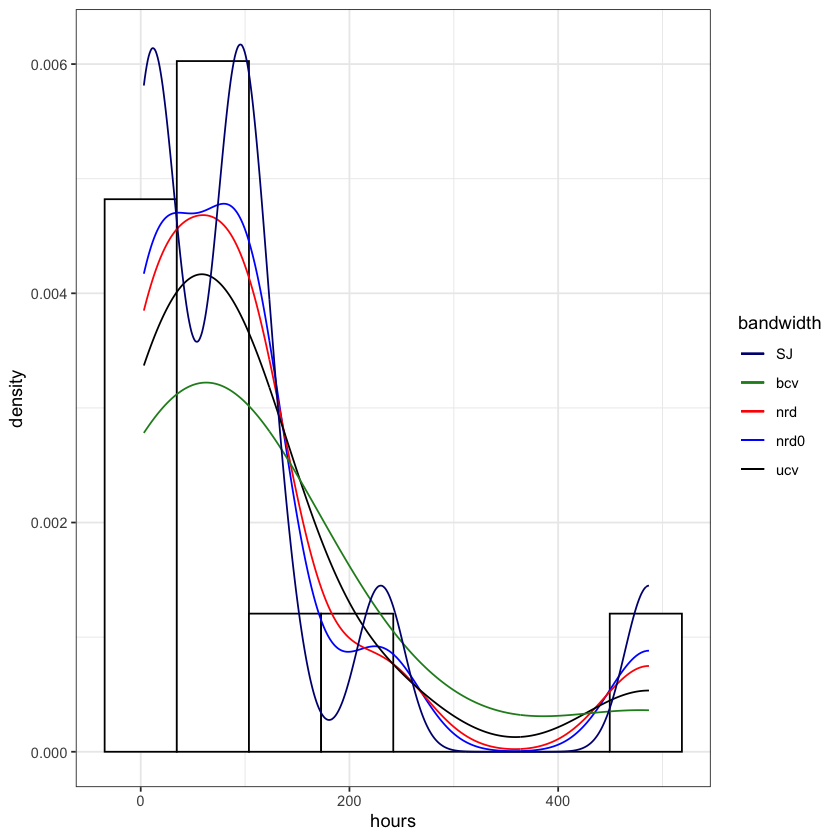

In [ ]:
ggplot(aircondit, mapping = aes(x = hours)) + geom_histogram(mapping = aes(y = after_stat(density)), bins = 8,
fill = "white", color = "black") +
stat_density(kernel = "gaussian", bw = h_nrd0, aes(color = "nrd0"), geom = "line") + stat_density(kernel = "gaussian", bw = h_nrd, aes(color = "nrd"), geom = "line") + stat_density(kernel = "gaussian", bw = h_ucv, aes(color = "ucv"), geom = "line") + stat_density(kernel = "gaussian", bw = h_bcv, aes(color = "bcv"), geom = "line") + stat_density(kernel = "gaussian", bw = h_SJ, aes(color = "SJ"), geom = "line") + scale_color_manual(name = "bandwidth",
values = c("nrd0" = "blue", "nrd" = "red", "ucv" = "black", "bcv" = "forestgreen", "SJ" = "navy")) +
theme_bw() + theme(legend.position = "right")

In [ ]:
aircondit_sim_gk <- function(data, mle){
data <- data
n <- nrow(data)
ind <- sample(1:n, size = n, replace = TRUE)
data$hours <- data$hours[ind] + mle*rnorm(n, 0, 1)
return(data)
}

In [ ]:
set.seed(136)
out_boot_aircondit_gk <- boot(data = aircondit, statistic = aircondit_mean,
                              R = 5000, sim = "parametric",
                              ran.gen = aircondit_sim_gk, mle = h_SJ)

In [ ]:
out_boot_aircondit_gk


PARAMETRIC BOOTSTRAP


Call:
boot(data = aircondit, statistic = aircondit_mean, R = 5000, 
    sim = "parametric", ran.gen = aircondit_sim_gk, mle = h_SJ)


Bootstrap Statistics :
    original     bias    std. error
t1* 108.0833 -0.4305168    38.17049

In [ ]:
boot.ci(out_boot_aircondit_gk, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 5000 bootstrap replicates

CALL : 
boot.ci(boot.out = out_boot_aircondit_gk, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 45.0, 191.3 )  
Calculations and Intervals on Original Scale